# Iskanje besed specifičnih za dokumente z uporabo obogatitve besed

V prejšnjem primeru smo iskali specifične besede za dokumente z vložitvami dokumentov. V tem primeru, pa bomo v ta namen uporabili metodo imenovano obgatitev besed (ang. Word enrichment).

Obogatitev besed izračuna p-vrednost za vsako od besed v množici vseh besed. Nižja p-vrednost pomeni večjo verjetnost, da je beseda značilna za izbrani dokument. 

In [1]:
import string

import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from IPython.display import display, Markdown
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

from textsemantics.server_api import ServerAPI
from utils.word_enrichment import hypergeom_p_values, FDR

Iz seznama predlogov vladi si izberimo zadnjih 100 dokumentov, jih predobdelajmo na isti način kot v prejšnjih primerih.

In [2]:
nltk.download('stopwords', quiet=True)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata(
    "proposals-to-government", sample_size=100, sampling_strategy='latest'
)
texts = [text for text in api.get_texts(urls=metadata['text']) if len(text) > 50]
tokens_list = preprocess(texts)

Najprej si izpišimo vse besede/izraze, ki smo jih dobili po preprocesiranju četrtega dokumenta. 

In [3]:
display(Markdown(", ".join(tokens_list[4])))

trenuten, obdavčitev, stanovanje, 120m2, hiša, 250m2, površina, presegati, cenzus, celoten, cena, obračun, ddv, stopnja, posledičen, stanovanje, površina, 121m2, več, dvakrat, bolj, obdavčen, stanovanje, površina, 119m2, absurden, predlagati, obdavčitev, spremeniti, površina, 120m2, stanovanje, 250m2, hiša, vedno, obdavčen, površina, presegati, cenzus, visok, obdavčen

V naslednjem koraku izračunamo značilke z metodo imenovano vreča based.

In [4]:
joined_texts = [' '.join(tokens) for tokens in tokens_list]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(joined_texts)
words = vectorizer.get_feature_names()

In [5]:
display(Markdown(f"Število besed v slovarju: {len(words)}"))

Število besed v slovarju: 2270

Ko imamo značilke lahko na podlagi teh najdemo značilne besede z metodo obogatitev besed. V prvem koraku bomo napisali funkcijo, ki izračuna p-vrednosti in FDR (popravljeno p-vrednost) za vsako besedo iz množice vseh besed za podani dokument. Funkcija vrne zgolj besede, ki imajo p-vrednosti manjše od 1. 

In [6]:
def specific_words(document_index):
    p_values = hypergeom_p_values(X, X[document_index])
    fdr = FDR(p_values)
    df = pd.DataFrame(
        {"Besede": words, "P-Vrednost": p_values, "FDR": fdr}
    ).sort_values("P-Vrednost", axis=0)
    return df[df["P-Vrednost"] < 1]

Pokažimo besedilo in značilne besede za dva dokumenta.

In [7]:
title = f"### {metadata.loc[4, 'title']}"
display(Markdown('\n'.join((title, texts[4]))))
specific_words(4)

### Sprememba stopnje DDV za stanovanjske nepremičnine
Trenutna obdavčitev je 9,5% za stanovanja do 120m2 in hiše do 250m2. Če površina presega cenzus, se na celotno ceno obračuna DDV po stopnji 22%. Posledično je stanovanje površine 121m2 več kot dvakrat bolj obdavčeno, kot stanovanje površine 119m2, kar je absurdno.
Predlagam, da se obdavčitev spremeni tako, da je površina do 120m2 stanovanja oz. 250m2 hiše vedno obdavčena po 9,5%. Površina, ki presega cenzus, pa naj bo višje obdavčena.

,Besede,P-Vrednost,FDR
1263,površina,0.010101,1.0
123,cenzus,0.010101,1.0
2,119m2,0.010101,1.0
3,120m2,0.010101,1.0
4,121m2,0.010101,1.0
23,absurden,0.010101,1.0
888,obdavčen,0.010101,1.0
915,obračun,0.010101,1.0
284,dvakrat,0.010101,1.0
13,250m2,0.010101,1.0


In [8]:
title = f"### {metadata.loc[13, 'title']}"
display(Markdown('\n'.join((title, texts[13]))))
specific_words(13)

### Videvanja z partnerjem z tujine med epidemijo.
Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp

,Besede,P-Vrednost,FDR
2084,vzdrževanje,0.010101,1.0
1490,punca,0.010101,1.0
1512,razdvojenost,0.010101,1.0
1077,partner,0.010101,1.0
1560,regija,0.010101,1.0
657,mahati,0.010101,1.0
694,mina,0.010101,1.0
1576,restriktiven,0.010101,1.0
555,kolpa,0.010101,1.0
2265,živ,0.020202,1.0


## Dendrogram z specifičnimi besedami

Sedaj, ko imamo postopek za računanje specifičnih besed, lahko te prikažemo v dendrogramu, ki prikazuje podobnosti med dokumenti. Ker bi bil dendrogram z vsemi dokumenti preobsežen, se odločimo za dokuemnte, ki smo jih že obravnavali v zvezku `03_02_distances_and_similarities`.

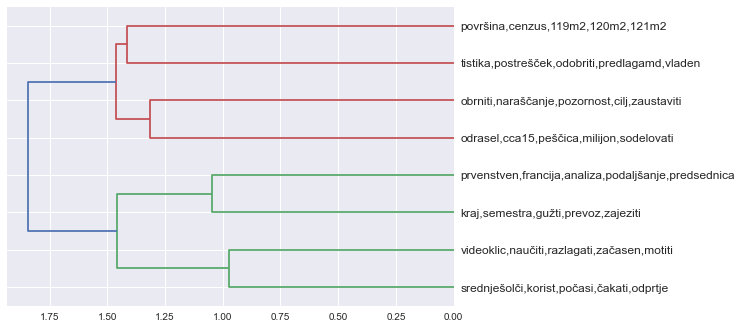

In [9]:
idx = [7, 18, 20, 30, 1, 2, 3, 4]

# dendrogram
plt.style.use('seaborn')
tfidf = X[idx, :]
dist_mat = 1 - cosine_similarity(tfidf)
linkage = ward(dist_mat)

# specific words
spec_words = [",".join(specific_words(i).iloc[:5]["Besede"].tolist()) for i in idx]
dendrogram(
    linkage, color_threshold=1.6, 
    labels=spec_words,
    orientation="left"
);